## Final Project Submission

Please fill out:
* Student name: Christopher Hollman
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


# Project Overview:

The country of Tanzania is partially dependent on a number of outside organizations and governments to supply water to the country's population. Since these water sources are funded, installed, and maintained by a number of different parties, it is a logistical challenge to oversee them all and anticipate which areas are in need of repair or replacement. This project aims to use machine learning to identify sources that are non functional or failing so that the Government of Tanzania can efficiently direct their limited resources to the areas that need them most. 

In [1]:
#importing necessary tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
training_labels = pd.read_csv('data/training_set_labels.csv')
training_values = pd.read_csv('data/training_set_values.csv')
combined_df = training_labels.merge(training_values)


## Initial Data Exploration:
The target variable for this dataset is currently split into three categories. For our purposes
any source that is not labeled as functional will need attention, eliminating the need to delineate
between the two other categories.

In [3]:
training_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [4]:
#Converting 3 labels into binary categories. 
label_conversions = {
    'functional':0,
    'functional needs repair':1,
    'non functional':1
}
y = training_labels['status_group'].replace(label_conversions) 

## Exploration of Predictors:
There are quite a few categories that seem to be very similar to one another if not redundant.
We will drop a number of these to simplify our model.

In [5]:
training_values.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [6]:
#These columns are either duplicates or more poorly categorized versions of columns that we kept

unusable_columns = ['id','date_recorded', 'wpt_name', 'num_private', 
                    'subvillage', 'lga', 'ward', 'recorded_by', 'extraction_type_group', 
                    'extraction_type', 'scheme_name', 'management', 'waterpoint_type_group', 
                    'source', 'source_class', 'quantity_group', 'quality_group', 
                    'payment_type', 'latitude', 'longitude']

In [7]:
X_vals = training_values.drop(unusable_columns, axis=1)
X_vals.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_type', 'waterpoint_type'],
      dtype='object')

### Dealing with missing values:
There are quite a few missing values, each of which we will deal with in a slightly different way. For construction
year we will take the median of the dataset excluding zero values (2000) and replace any zeros with this number. 
For scheme management we will label these values as 'unknown'. For funder and installer we will list them with the majority of the values as 'other'. I used the 'pad' method for public meeting and permit in order to preserve the ratio of yes/no values.

In [8]:
X_vals.isna().sum()

amount_tsh                  0
funder                   3635
gps_height                  0
installer                3655
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source_type                 0
waterpoint_type             0
dtype: int64

In [9]:
X_vals['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [10]:
#Zeros seem to be okay here, as most of are values are quite low, indicating that this is likely a real number
#rather than a numerical placeholder.

X_vals['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [11]:
#Categorizing unknown values as such

X_vals['scheme_management'].fillna('Unknown', inplace=True)

In [12]:
#padding true/false categories and converting to integers

X_vals['public_meeting'] = X_vals['public_meeting'].fillna(method='pad').astype(int)

X_vals['permit'] = X_vals['permit'].fillna(method='pad').astype(int)

### Funder/Installer Columns:
These columns posed a challenge in that the appear to have been entered manually, resulting in
extremely high cardinality and many entries that are close to one another but misspelled or abbreviated.
I limited my categories to the top 30, cleaned those entries up as best I could and categorized the rest as 'other'

In [13]:
#replacing unknown construction years with median value

print(X_vals['construction_year'].value_counts())
X_vals['construction_year'].replace(0,2000, inplace=True)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64


In [14]:

top_installers = set(X_vals['installer'].value_counts().index[:30].values)
top_funders = set(X_vals['funder'].value_counts().index[:30].values)
print(top_installers)
print(top_funders)

{'OXFAM', 'Government', 'Gover', 'HESAWA', 'Community', 'DWE', 'ACRA', 'TCRS', 'District Council', 'World vision', 'District council', 'Commu', 'Dmdd', 'LGA', 'SEMA', 'CES', 'WEDECO', 'TWESA', 'RWE', 'KKKT', 'Central government', 'Hesawa', 'AMREF', 'DANID', 'DANIDA', 'WU', 'DW', 'World Vision', '0', 'TASAF'}
{'Hifab', 'Amref', 'World Bank', 'Dhv', 'Wateraid', 'Oxfam', 'Private Individual', 'Tasaf', 'Government Of Tanzania', 'District Council', 'Danida', 'Norad', 'Tcrs', 'Rwssp', 'Germany Republi', 'Adb', 'Unicef', 'Dwsp', 'Isf', 'Lga', 'Water', 'Kkkt', 'Hesawa', 'Rc Church', 'Fini Water', 'Netherlands', 'Dwe', 'World Vision', '0', 'Ministry Of Water'}


In [15]:
#combining similar labels within top 30 and replacing remaining values with 'other'

installer_replace = {
    'Commu':'Community',
    '0':'Unknown',
    'DANID':'DANIDA',
    'District council':'District Council',
    'DW':'DWE',
    'Gov':'Government',
    'Gover':'Government',
    'Central Government':'Government',
    'HESAWA':'Hesawa',
    'World vision':"World Vision"
}

X_vals['installer'].replace(installer_replace, inplace=True)

X_vals['funder'].replace('0','Unknown', inplace=True)

top_installers = set(X_vals['installer'].value_counts().index[:30].values)
top_funders = set(X_vals['funder'].value_counts().index[:30].values)

In [16]:
for i in range(len(X_vals)):
    if X_vals['installer'][i] not in top_installers:
        X_vals['installer'][i] = 'Other'

for i in range(len(X_vals)):
    if X_vals['funder'][i] not in top_funders:
        X_vals['funder'][i] = 'Other'        

In [17]:
X_vals['installer'].value_counts()

Other                         23679
DWE                           17648
Government                     2318
Community                      1613
DANIDA                         1602
Hesawa                         1379
RWE                            1206
District Council                943
KKKT                            898
Unknown                         780
TCRS                            707
World Vision                    678
Central government              622
CES                             610
LGA                             408
WEDECO                          397
TASAF                           396
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                            278
SEMA                            249
OXFAM                           234
Da                              224
UNICEF                          222
Gove                            222
Idara ya maji               

In [18]:
X_vals['funder'].value_counts()

Other                     26129
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
District Council            843
Dhv                         829
Private Individual          826
Dwsp                        811
Unknown                     781
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Dwe                         484
Netherlands                 470
Hifab                       450
Adb                         448
Lga                         442
Amref                       425
Fini Water                  393
Oxfam                       359
Wateraid                    333
Rc Church                   321
Isf                         316
Name: fu

In [19]:
#Converting region and district codes to avoid them being treated as continuous

X_vals['region_code'] = X_vals['region_code'].astype(object)
X_vals['district_code'] = X_vals['district_code'].astype(object)

## Fitting Decision Tree Model:
The model we will use as a baseline will be an untuned Decision tree. This is a relatively simple yet effective model 
that doesn't require any scaling of our data. 

In [20]:
#Creating dummy variables for categorical data

X_vals = pd.get_dummies(X_vals)

In [21]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(X_vals, y, test_size=.30, random_state=0)

In [23]:
# Fitting Decision Tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
 
print('Untuned Decison Tree Scores: \n', classification_report(y_test,clf_dt.predict(X_test)))


Untuned Decison Tree Scores: 
               precision    recall  f1-score   support

           0       0.79      0.82      0.80      9612
           1       0.78      0.74      0.76      8208

    accuracy                           0.78     17820
   macro avg       0.78      0.78      0.78     17820
weighted avg       0.78      0.78      0.78     17820



### Untuned Decision Tree Performance:
The metrics to focus on are precision and recall for 1 values. This model has .77 precision, meaning that
it is correct 77% of the time when it predicts that a water sources is in need or repair or replacement. The .74 recall score indicates that this model correctly identifies 74% of total sources that are in our target category. This is a very serviceable baseline model but can likely be improved.

In [24]:


param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 15, 20, 25, 30],
    'min_samples_split': [10, 12, 14, 15, 16, 17]
}

gs_tree = GridSearchCV(clf_dt, param_grid_dt, cv=3)
gs_tree.fit(X_train, y_train)

print(gs_tree.best_params_)
print(gs_tree.best_score_)

{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 15}
0.7793169793169793


In [25]:
clf_dt_2 = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=20, 
    min_samples_split=10
)
clf_dt_2.fit(X_train, y_train)
print('Tuned Decison Tree Scores: \n', classification_report(y_test,clf_dt_2.predict(X_test)))
 

Tuned Decison Tree Scores: 
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      9612
           1       0.82      0.70      0.76      8208

    accuracy                           0.79     17820
   macro avg       0.80      0.79      0.79     17820
weighted avg       0.80      0.79      0.79     17820



### Tuned Decision Tree Performance:
With these tuned parameters our model is more precise (82%) when categorizing a source as in need of repair, however
it has lost performance in terms of missing more sources that should be flagged as in need of service. The overall
accuracy of the model improved marginally. 

## Fitting a Random Forest Model:
Given the amount of noise present in our data, it is likely that we can improve our model but fitting a random
forest model made up of a consensus of many simple decision trees. 

In [26]:
#fit random forest 
clf_rf = RandomForestClassifier(random_state=42) 
clf_rf.fit(X_train,y_train)
print('Random Forest Scores \n', classification_report(y_test,clf_rf.predict(X_test)))

Random Forest Scores 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      9612
           1       0.82      0.76      0.79      8208

    accuracy                           0.81     17820
   macro avg       0.81      0.81      0.81     17820
weighted avg       0.81      0.81      0.81     17820



### Untuned Random Forest Performance:
This more complex model resulted in a similar precision for our target category without the drop off in recall as well as better overall accuracy. This is already a good improvement over decision trees, which is to be expected given how noisy our data is.

In [34]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [1, 3, 5]
}


gs_forest = GridSearchCV(clf_rf, param_grid_rf, cv=3)
gs_forest.fit(X_train, y_train)

print(gs_forest.best_params_)
print(gs_forest.best_estimator_)
print(gs_forest.best_score_)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=150, random_state=42)
0.8118742985409653


In [22]:
clf_rf_2 = RandomForestClassifier(
    n_estimators=150,
    criterion='entropy',
    max_depth=None,
    min_samples_split = 10,
    min_samples_leaf = 1,
    random_state=42) 
clf_rf_2.fit(X_train, y_train)
print('Tuned Random Forest Scores \n', classification_report(y_test,clf_rf_2.predict(X_test)))

Tuned Random Forest Scores 
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      9612
           1       0.84      0.75      0.79      8208

    accuracy                           0.82     17820
   macro avg       0.82      0.81      0.81     17820
weighted avg       0.82      0.82      0.82     17820



### Tuned Random Forest Performance: 
We were able to increase the precision of our model for our target category by 2 points at the cost of 1 point of recall, which is somewhat acceptable. Overall model accuracy increased by one point as well. 

## Fitting XG Boost Model
This tends to be one of the more accurate models readily available for classification tasks. It should perform similarly or better as compared to the Random Forest model. 

In [29]:
# XGBoost
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train,y_train)
print('XG Boost Scores \n', classification_report(y_test,clf_xgb.predict(X_test)))

XG Boost Scores 
               precision    recall  f1-score   support

           0       0.78      0.89      0.83      9612
           1       0.84      0.71      0.77      8208

    accuracy                           0.81     17820
   macro avg       0.81      0.80      0.80     17820
weighted avg       0.81      0.81      0.80     17820



### Untuned XG Boost Model Performance:
An untuned XB Boost model results in similar but slightly lower scores than our tuned random forest.

In [37]:
param_grid_xgb = {
    'learning_rate': [0.1, .2, .3],
    'max_depth': [2,4,6],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [100, 150, 200]
}

In [38]:
gs_boost = GridSearchCV(clf_xgb, param_grid_xgb, cv=3)
gs_boost.fit(X_train, y_train)
print(gs_boost.best_params_)
print(gs_boost.best_estimator_)
print(gs_boost.best_score_)

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)
0.8042648709315378


In [30]:
clf_xgb_2 = XGBClassifier(learning_rate=0.3, max_depth= 6, n_estimators= 200, subsample=0.7)
clf_xgb_2.fit(X_train, y_train)
print('Tuned XG Boost Scores \n', classification_report(y_test,clf_xgb_2.predict(X_test)))

Tuned XG Boost Scores 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      9612
           1       0.83      0.74      0.78      8208

    accuracy                           0.81     17820
   macro avg       0.81      0.80      0.81     17820
weighted avg       0.81      0.81      0.81     17820



### Tuned XG Boost Model Performance:
None of the parameters in the grid search resulted in appreciably better performance. The tuned Random Forest
model has the best mix of precision and recall for the target group, meaning that a good portion of failures are being correctly categorized without wasting government resources investigating wells that are actually working properly. 

In [56]:
importances = clf_rf_2.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

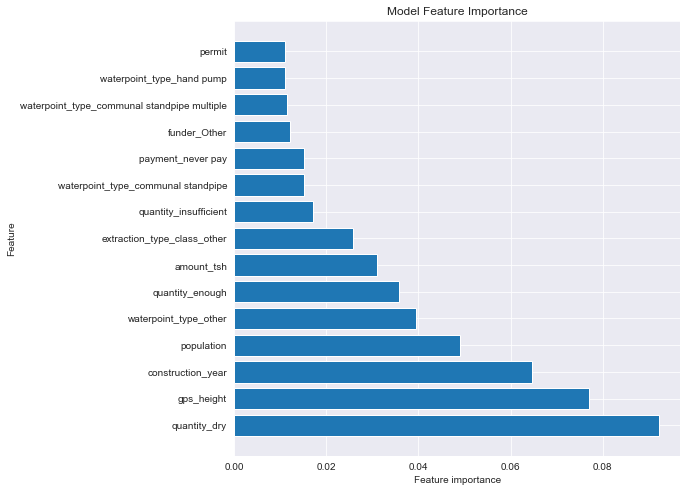

In [23]:
def plot_feature_importances(model):
    sns.set_style('darkgrid')
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    n_features = 15
    plt.figure(figsize=(8,8))
    plt.barh(range(15), importances[sorted_indices][:15], align='center') 
    plt.yticks(range(n_features), X_train.columns[sorted_indices][:15])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Model Feature Importance')
plot_feature_importances(clf_rf_2)

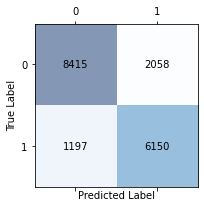

In [45]:
y_pred = clf_rf_2.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig,ax = plt.subplots(figsize=(3,3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for x in range(confmat.shape[0]):
    for y in range(confmat.shape[1]):
        ax.text(x=x,y=y,
               s=confmat[x,y],
               va='center', ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Model Interpretation:
The most important features for this model are the waterpoint being categorized as dry, the altitude of the well and the year it was built/installed. There are quite a few 0 values in the GPS height column so looking deeper into the accuracy of those numbers may be useful to improve model performance. Also interestingly, not all of the waterpoints that are described as "dry" are labeled as non functional. 

## Conclusion/Next Steps: 
This model is able to accurately categorize a failing/failed water source 84% of the time, while detecting 75 percent of the total sources in need of repair or replacement. This is a good starting point and results in a much more efficient approach compared to a nationwide routine inspection of all wells. The major limitations of this model lie with the data itself and some improvement in performance could be gained by:
1. Reclassifying/aggregating the extensive list of funders/installers.
2. Looking deeper into GPS height, which was one of our top features in terms of performance.
3. Ranking flagged sites in terms of urgency.

## Graphing Data

In [226]:
regions = combined_df.groupby('region')['status_group'].value_counts().unstack()
regions['total'] = regions['non functional']+regions['functional needs repair']+regions['functional']
regions['failure_rate'] = (regions['non functional']+regions['functional needs repair'])/regions['total']
regions = regions.sort_values('failure_rate', ascending=False)

status_group,functional,functional needs repair,non functional,total,failure_rate
region,,,,,
Lindi,460,93,993,1546,0.702458
Mtwara,524,126,1080,1730,0.697110
Rukwa,707,135,966,1808,0.608960
Tabora,848,45,1066,1959,0.567126
Mara,886,60,1023,1969,0.550025
Dodoma,1009,209,983,2201,0.541572
Singida,1011,128,954,2093,0.516961
Kigoma,1363,603,850,2816,0.515980
Mwanza,1502,183,1417,3102,0.515796


In [227]:
regions.reset_index(inplace=True)

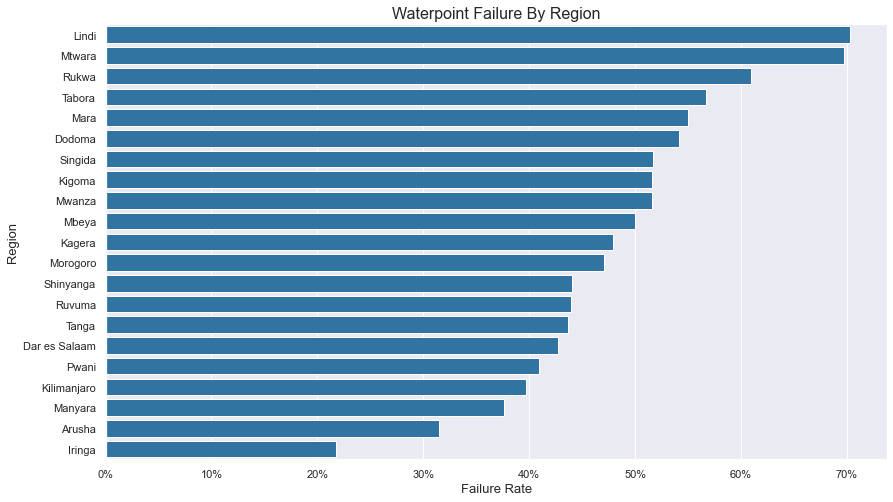

In [245]:
ax = plt.subplots(figsize=(14,8))
sns.set_theme(style="darkgrid")
sns.set()
ax = sns.barplot(
    y = regions['region'], 
    x = regions['failure_rate']*100, 
    color = "tab:blue",
    data = regions, orient="h")
ax.set_xlabel("Failure Rate", fontsize=13)
ax.set_ylabel("Region", fontsize=13)
ax.set_title("Waterpoint Failure By Region", fontsize=16)
    
ax.xaxis.set_major_formatter(mtick.PercentFormatter());
